# Generating Shakespeare character by character

This is a small example of a GPT that is trained on Shakespeare text. This notebook has major inspiration from https://github.com/karpathy/nanoGPT. It's great to get familiar and play around with GPT alwhile not necessarly having a cluster of 1000s of GPUs.

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import torch
from nanoLLMs.misc import get_batch
from nanoLLMs.misc import generate_text
from nanoLLMs.model import GPT2, Mamba, mLSTM
from nanoLLMs.trainer import Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We launch the `data/shakespeare_char/prepare.py` file in order to have our data setup.

In [2]:
! python ../data/shakespeare_char/prepare.py 

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens


In this dataset we have 65 unique characters that forms our vocabulary size, 1M tokens for training and 100k for validation.

In [3]:
data_dir = "../data/shakespeare_char/"
meta_path = os.path.join(data_dir, "meta.pkl")
vocab_size = None

if os.path.exists(meta_path):
    with open(meta_path, "rb") as f:
        meta = pickle.load(f)
    vocab_size = meta["vocab_size"]
    itos = meta["itos"]
    stoi = meta["stoi"]
    print(f"found vocab_size = {vocab_size} (inside {meta_path})")

found vocab_size = 65 (inside ../data/shakespeare_char/meta.pkl)


We then get some meta data and other convienences. For example, the GPT trained hereafter will have the task of predicting the next Shakesperian character given its context. Autoregressively, you can generate many characters that will eventually form words and sentences.

The function `encode` and `decode` will help to bridge the gap between produced GPT output into readable characters and readable characters into data.

We also provide an example of how a `str` is encoded for the model and how the model's output `array` of `int` are decoded to produce Shaspearian literature.

In [4]:
encode = lambda s: torch.tensor([stoi[c] for c in s])
decode = lambda l: "".join([itos[i] for i in l])

shakpeare_lines = "the king will"
x = encode(shakpeare_lines)
y = decode(x.tolist())
assert shakpeare_lines == y

print("The text '{}' is encoded and fed to the GPT as {}".format(shakpeare_lines, x))

The text 'the king will' is encoded and fed to the GPT as tensor([58, 46, 43,  1, 49, 47, 52, 45,  1, 61, 47, 50, 50])


We then choose to use the same hyperparameters from https://github.com/karpathy/nanoGPT for a small example of CPU. 

In [5]:
block_size = 64
n_layer, n_head, n_embd, dropout = 4, 4, 128, 0.0

model = GPT2(vocab_size, block_size, n_embd, n_head, n_layer)
model = model.to(device)
print("GPT number of parameters:", sum(p.numel() for p in model.parameters()))

GPT number of parameters: 813889


We instantiate also our `GPTTrainer` code from `nanoLLMs/trainer/gpt_trainer.py`. 

In [6]:
trainer = Trainer(model, lr=1e-3, checkpoint_path="../metadata/shakespeare_char/")

Created checkpoint directory at ../metadata/shakespeare_char/


We call the `train` method from our `trainer` that takes as input : 
- `get_batch`: a function that fetches batches of data
- `max_iters`: number of max iterations
- `batch_size`: batch size 
- `patience`: an argument that essentially stops the training if the validation loss hasn't improve in `#patience` optimization steps. 
- `save_every`: that saves the model weights and other things at `save_every` multiples of iteration step. 

In [7]:
partial_get_batch = lambda split, batch_size: get_batch(
    data_dir, split, batch_size, device, block_size
)
trainer.train(
    partial_get_batch, max_iters=200, batch_size=2*128, patience=2000, save_every=200
)

Iter :199/200 Train Loss 2.040e+00 / Eval Loss 2.090e+00: 100%|██████████| 200/200 [00:32<00:00,  6.09it/s]


Let's see the loss curve from this training and also generate some text !

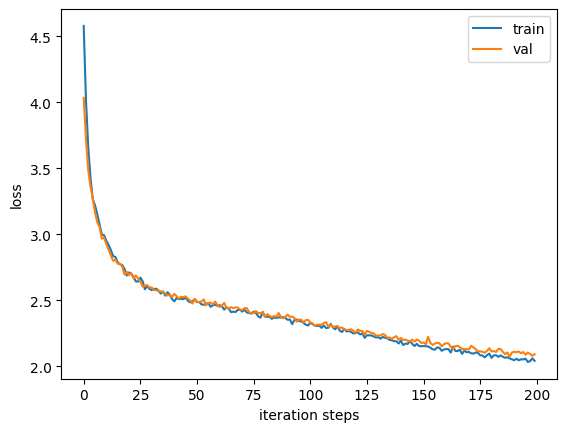

In [8]:
plt.plot(trainer.losses, label="train")
plt.plot(trainer.val_losses, label="val")
plt.xlabel("iteration steps")
plt.ylabel("loss")
plt.legend()
plt.savefig("../metadata/shakespeare_char/gpt_loss.png")

We also added a `temperature` and `top_k` hyperparameters to give a bit more flexibility to the text generation. 

In [9]:
input = "The "
tokens = encode(shakpeare_lines).view(1,-1)
tokens = tokens.to(device)
sample_text = generate_text(model, tokens, 2* 256, temperature=0.7)
print("Generated Text:")
print(decode(sample_text.tolist()[0]))

Generated Text:
the king will and whord,
I st dusple loovereds thing dots vis thear min
Fill the wis seaplive arn ware ustrop the you
My here she spease the be maing
And thou at he sthe hould adsais with bede,
The is loverst sto he--
The thim saide shim now the spert: my cren't os lowand
That be is the of Risen eplight mis whath he kis my
Thous and he hisuth bee good send hand me sued
Bot of the in she the all not me sis are.

MISTIETIS:

No for I be light suiving ads, hers with sher

Whith us derrs nouth bet outherd I an ther walf shi


# Text generation with Mamba

In [10]:
import os
import pickle

import matplotlib.pyplot as plt
import torch
from nanoLLMs.misc import get_batch
from nanoLLMs.trainer import Trainer

In [11]:
data_dir = "../data/shakespeare_char/"
meta_path = os.path.join(data_dir, "meta.pkl")
vocab_size = None

if os.path.exists(meta_path):
    with open(meta_path, "rb") as f:
        meta = pickle.load(f)
    vocab_size = meta["vocab_size"]
    itos = meta["itos"]
    stoi = meta["stoi"]
    print(f"found vocab_size = {vocab_size} (inside {meta_path})")

found vocab_size = 65 (inside ../data/shakespeare_char/meta.pkl)


In [12]:
encode = lambda s: torch.tensor([stoi[c] for c in s])
decode = lambda l: "".join([itos[i] for i in l])

shakpeare_lines = "the king will"
x = encode(shakpeare_lines)
y = decode(x.tolist())
assert shakpeare_lines == y

print("The text '{}' is encoded and fed to the GPT as {}".format(shakpeare_lines, x))

The text 'the king will' is encoded and fed to the GPT as tensor([58, 46, 43,  1, 49, 47, 52, 45,  1, 61, 47, 50, 50])


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d_model, expand, kernel_size, conv_bias, dt_rank, d_state, bias, dt_max, dt_min, dt_init_floor, dt_scale, n_layers, dt_init, use_cuda = 32, 2, 4, False, "auto", 16,  True, 0.1, 0.001, 1e-4, 1.0, 6, "random", True
model = Mamba(d_model, expand, kernel_size, conv_bias, dt_rank, d_state, bias, dt_max, dt_min, dt_init_floor, dt_scale, dt_init, use_cuda, n_layers, vocab_size=vocab_size, block_size=256)
model = model.to(device)

Failed to import mamba_ssm. Falling back to mamba.py.
Failed to import mamba_ssm. Falling back to mamba.py.
Failed to import mamba_ssm. Falling back to mamba.py.
Failed to import mamba_ssm. Falling back to mamba.py.
Failed to import mamba_ssm. Falling back to mamba.py.
Failed to import mamba_ssm. Falling back to mamba.py.


In [14]:
max_iters, batch_size = 1000, 32
block_size = 64
get_batch_fn = lambda split, batch_size: get_batch(
    data_dir, split, batch_size, device, block_size
)

In [15]:
trainer = Trainer(model, lr=1e-3, checkpoint_path="../metadata/shakespeare_char/")

Created checkpoint directory at ../metadata/shakespeare_char/


In [16]:
partial_get_batch = lambda split, batch_size: get_batch(
    data_dir, split, batch_size, device, block_size
)
trainer.train(
    partial_get_batch, max_iters=500, batch_size=2*128, patience=2000, save_every=200
)

Iter :499/500 Train Loss 1.706e+00 / Eval Loss 1.863e+00: 100%|██████████| 500/500 [06:20<00:00,  1.31it/s]


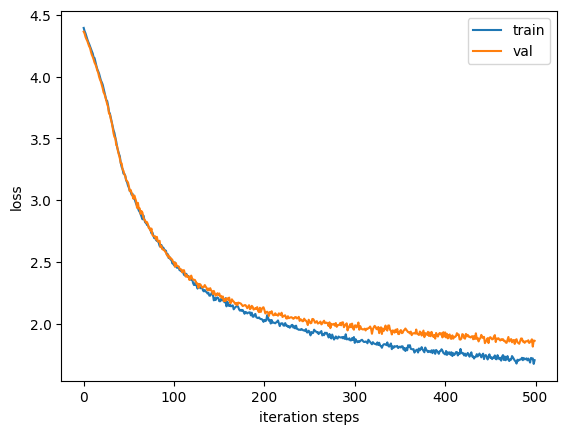

In [17]:
plt.plot(trainer.losses, label="train")
plt.plot(trainer.val_losses, label="val")
plt.xlabel("iteration steps")
plt.ylabel("loss")
plt.legend()
plt.savefig("../metadata/shakespeare_char/mamba_loss.png")

In [18]:
input = "The "
tokens = encode(shakpeare_lines).view(1,-1)
tokens = tokens.to(device)
sample_text = generate_text(model, tokens,1256, temperature=0.7)
print("Generated Text:")
print(decode(sample_text.tolist()[0]))

Generated Text:
the king will the lady proven.

GRCORUS:
O thou shall pale to hand is my have upon shall me you are at the seelenges, powere he do dight your the commons
And but way strent,
And for suppeolet,
But or flest, thee daughter, thy heart to thy not
To bid retend
Where more all tome the ra't thee!

Second; the kingdeat in the sudes to may the world, in for sirti forth more
Come me hanswel diuk;
Your come and not thou say
And life
Here you the apmarash woether in stand heart
'tanion, and stram.

ERCAT:
O the sir, thou thou hand Toow have me
us too your resingal the world he wenders thy sife's all to sir.

ROMEO:
What day on it be could it my cames and their brother to that what me world, and glory
And endea
Why forth come to in shipe I see
Servant our never till holesant been though of the desolconsesteds.

CICLA:
He the so our alice to stafe; it ender, from is can will come.

SICIkw out to the purse father good by so,
What me most thee cleased, it this come, and him thee all t

# xLSTM 

In [19]:
from nanoLLMs.model.xlstm import xLSTM

In [20]:
embed_dim = 128
hidden_size = 256
num_layers = 2
num_blocks = 3
dropout = 0.1
max_seq_len = 256

model = xLSTM(vocab_size, embed_dim, max_seq_len, hidden_size, num_layers, num_blocks, dropout)
model.to(device)
print("xLSTM number of parameters:", sum(p.numel() for p in model.parameters()))

xLSTM number of parameters: 1895617


In [21]:
max_iters, batch_size = 1000, 32
block_size = 64
get_batch_fn = lambda split, batch_size: get_batch(
    data_dir, split, batch_size, device, block_size
)

In [22]:
trainer = Trainer(model, lr=1e-3, checkpoint_path="../metadata/shakespeare_char/")

Created checkpoint directory at ../metadata/shakespeare_char/


In [23]:
partial_get_batch = lambda split, batch_size: get_batch(
    data_dir, split, batch_size, device, block_size
)
trainer.train(
    partial_get_batch, max_iters=1000 , batch_size=batch_size, patience=2000, save_every=200
)

Iter :2499/2500 Train Loss 1.423e+00 / Eval Loss 1.530e+00: 100%|██████████| 2500/2500 [34:24<00:00,  1.21it/s]


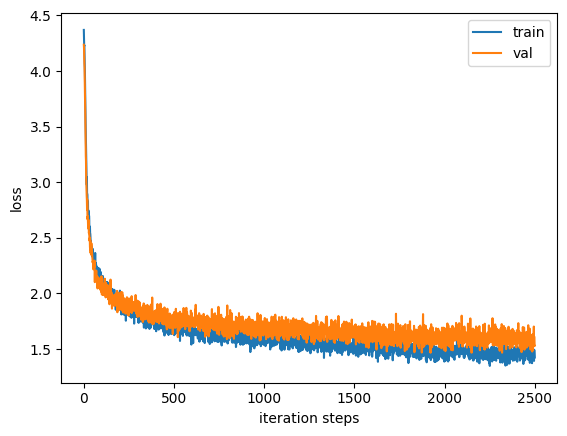

In [24]:
plt.plot(trainer.losses, label="train")
plt.plot(trainer.val_losses, label="val")
plt.xlabel("iteration steps")
plt.ylabel("loss")
plt.legend()
plt.savefig("../metadata/shakespeare_char/xlstm_loss.png")

In [27]:
input = "The "
tokens = encode(shakpeare_lines).view(1,-1)
tokens = tokens.to(device)
sample_text = generate_text(model, tokens, 256, temperature=0.7)
print("Generated Text:")
print(decode(sample_text.tolist()[0]))

Generated Text:
the king will bury on the wholesome down,
Carriol's doth do the matching as this way
That with death, how I hhave been love your form.

AUFIDIUS:
God happy bear me and the child,
And the save a town made me with the way;
And, he shall be his words are twenty the strick
